# Päätöspuut ja satunnaismetsät

## Ongelman Ymmärrys
Tämän analyysin tarkoituksena on käyttää kahta erilaista koneoppimismallia phising-sivustojen tunnistamiseen. Käytämme mallien kouluttamiseen ja testaamiseen UCI:n Phising Websites datasettiä. Toivottuna lopputuloksena olisi saada tehokas malli joka voi tunnistaa onko sivusto tavallinen vai phising-sivusto.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

df = pd.read_csv('phishing_websites.csv')

X = df.drop('Result', axis=1)
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Datan arvojen selitys
- **having_ip_address**: Jos URL-osoite on ilmaistu IP-osoitteella kuten '125.98.3.123' perinteisen DNS-nimen sijaan voidaan olettaa sivuston olevan phising-sivusto.
- **url_length**: Mikäli URL-osoitteen pituus on alle 54 voidaan olettaa, että sivusto on aito. Jos osoite on yli 54, sivusto luokitellaan epäilyttäväksi. Jos osoite on yli 75, se luokitellaan phishing-sivustoksi
- **shortining_service**: Phishing sivut käyttävät lyhyitä url-osoitteita, piilottamaan loput linkin osoitteesta.
- **having_at_symbol**: Phishing sivut sisältävät url osoitteessa `@` merkin, joka antaa selaimen hylätä merkin jälkeen kirjoitetut tiedot.
- **double_slash_redirecting**: Phishing-sivustot lisäävät kaksi kauttaviivaa `//` url-osoitteen loppuun, joka johtaa eri paikkaan.
- **prefix_suffix**: Phishing-sivustot yleises yrittävät lisätä `-` merkin URL osoite nimeen (johonkin kohtaan), jotta se näyttäisi enemmän aidolta. Voidaan olettaa myös, että ilman `-` merkkiä olevat sivuston URL-ositteet luokitellaan aidoiksi sivuiksi.
- **having_sub_domain**: Jos sub domain osoite sisältää yhden piteen se on aito, jos siinä on kaksi pistettä se on phishing sivu, muuten se on epäylyttävä.
- **sslfinal_state**: HTTPS ei usein riitä sivuston turvallisuuden takaamiseen, joten on hyvä tarkistaa sivuston HTTPS-sertifikaatin ikä ja antaja, jotta voidaan saada parempi idea sivuston turvallisuudesta. Jos sivusto käyttää HTTPS-protokollaa, sen antaja on luotettu ja sivuston sertifikaatin ikä on 1 vuosi tai enemmän, sivusto luokitellaan aidoksi. Jos sivusto käyttää HTTPS-protokollaa, mutta sen antaja ei ole luotettu, sivusto luokitellaan epäilyttäväksi. Muissa tapauksissa sivusto luokitellaan phishing-sivustoksi.
- **domain_registration_length**: Phishing-sivustot eivät yleensä ole pystyssä hyvin pitkään, joten jos sivuston domain on vanhentumassa pian, sivusto on luultavasti phishing-sivu. UCI:n datasetistä ollaan tultu johtopäätökseen, että vanhimmat phishing-domainit ovat olleet käytössä yhden vuoden. Jos sivuston domain on vanhentumassa alle vuoden päästä, se luokitellaan phishing-sivustoksi. Muuten se luokitellaan aidoksi.
- **favicon**: Jos sivuston favicon-ikoni ladataan ulkoiselta domainilta, sivusto luokitellaan phishing-sivuksi. Muuten se luokitellaan aidoksi.
- **port**: Aidot sivut pitävät vain portteja `80` (http) ja `443` (https) auki. Phishing sivut pitävät yleensä tämän lisäksi extra portteja tietojen jakamiseen tai etäyhteyksiin. 
- **https_token**: Phishing-sivut saattavat lisätä domainin url:iin "https" kirjainyhdistelmän huijatakseen sivuston käyttäjiä luulemaan sivuston olevan turvallinen. Jos sivuston urlista siis löytyy "https" se luokitellaan phishing-sivustoksi.
- **request_url**: Phishing-sivut sisältävät video, kuva, ääni tai muita elementtejä jotka linkkaavat toisten sivujen domainiin.
- **url_of_anchor**: Phishing sivut sisältää toisten sivujen domain linkkejä
- **links_in_tags**: Aitojen sivujen käyttämät `meta` ja `link` tagit eivät linkitä ulkoiseen domainiin.
- **sfh**: "about:blank" url osoitteet ovat Phishing sivuja, koska ne eivät yleensä ota yhteyttä serveriin (yleensä serverit hyväksyvät vain tietystä domainista tulevat kutsut, mutta "about:blank" urlia voi käyttää kuka vain).
- **submitting_to_email**: Phishing sivut käyttää `mail()` tai `mailto` funktioita lähettämään tietoja sähköpostiinsa.
- **abnormal_url**: Aitojen sivujen urlit löytyvät `WHOIS` tietokannasta, jos domain nimeä ei löydy se on Phishing sivu.
- **redirect**: Sivut jotka uudelleenohjaavat enintään kerran ovat aitoja, kahdesta neljään uudelleenohjausta on epäilyttävää ja loput ovat Phishing sivuja.
- **on_mouseover**: Phishing sivut sisältävät `onMouseOver` tapahtumia, jotka vaihtavat sivun status palkin osoitetta
- **rightclick**: Phishing sivut estävät käyttäjän oikean hiiren painikkeen kontekstivalikon.
- **popupwindow**: Phishing sivut kysyvät käyttäjä tietoja popup ikkunoissa.
- **iframe**: Phishing sivut piilottavat `iframe` elementtejä poistamalla elementin reunat näkyvistä.
- **age_of_domain**: WHOIS-tietokannasta saatu tieto domainin iästä. Phishing sivut eivät ole pystyssä pitkään, joten niiden ikä on usein pieni. Jos sivuston ikä on alle 6 kuukautta, se luokitellaan phishing-sivustoksi. Muuten se luokitellaan aidoksi.
- **dnsrecord**: Jos sivuston DNS-tieto ei löydy tai ei tunnisteta WHOIS-tietokannassa, sivu luokitellaan phishing-sivustoksi. Muuten sivu luokitellaan aidoksi.
- **web_traffic**: Tämä arvo saadaan luokittelemalla sivustoja niiden käyttäjien määrän perusteella. Jos sivusto löytyy Alexa-tietokannan 100 000 vierailluimman sivuston joukosta, sivusto luokitellaan aidoksi. Jos sivusto löytyy tietokannasta, mutta ei löydy 100 000 vierailluimmaan sivustojen joukosta, mutta on kuitenkin tietokannassa, sivusto luokitellaan epäilyttäväksi. Muuten sivusto on phishing-sivusto.
- **page_rank**: PageRank arvo ilmaisee sivuston tärkeyttä internetissä. Mitä suurempi arvo, sitä tärkeämpi sivusto. UCI:n datasettien mukaan noin 95% phishing-sivustoista saa PageRank arvon 0 ja ylijääneet 5% saa maksimissaan 0.2 arvoksi. Jos sivuston arvo on siis alle 0.2, sivusto luokitellaan phishing-sivustoksi, muuten se luokitellaan aidoksi.
- **google_index**: Tämä arvo kertoo sen, löytyykö sivusto Googlen indeksistä. Kun Google indeksoi sivun, se löytyy Google-haun tuloksena. Jos sivusto ei kuulu tähän indeksiin, sen luokitellaan olevan phishing-sivusto. Koska phishing sivustot eivät ole usein pitkään pystyssä, niitä ei usein löydetä Googlen indeksistä. 
- **links_pointing_to_page**: Sivustoon johtavien linkkien määrä. Jos sivustoon johtavia linkkejä on 0, sivusto on phishing-sivusto. Jos linkkejä on 1-2, sivusto luokitellaan epäilyttäväksi. Kun linkkejä on enemmän kuin 2, sivuston katsotaan olevan aito sivu. 
- **statistical_report**: Jos sivuston domain tai IP kuuluu johonkin tunnettujen phishing-sivustojen listaan, se tarkoittaa sivuston olevan phising-sivusto.

## Datan valmistelu
Pudotimme datasta pois result-sarakkeen, muuten data jäi koskemattomaksi, koska datan ylimääräistä karsimista ei nähty tarpeelliseksi tämän datasetin kohdalla.

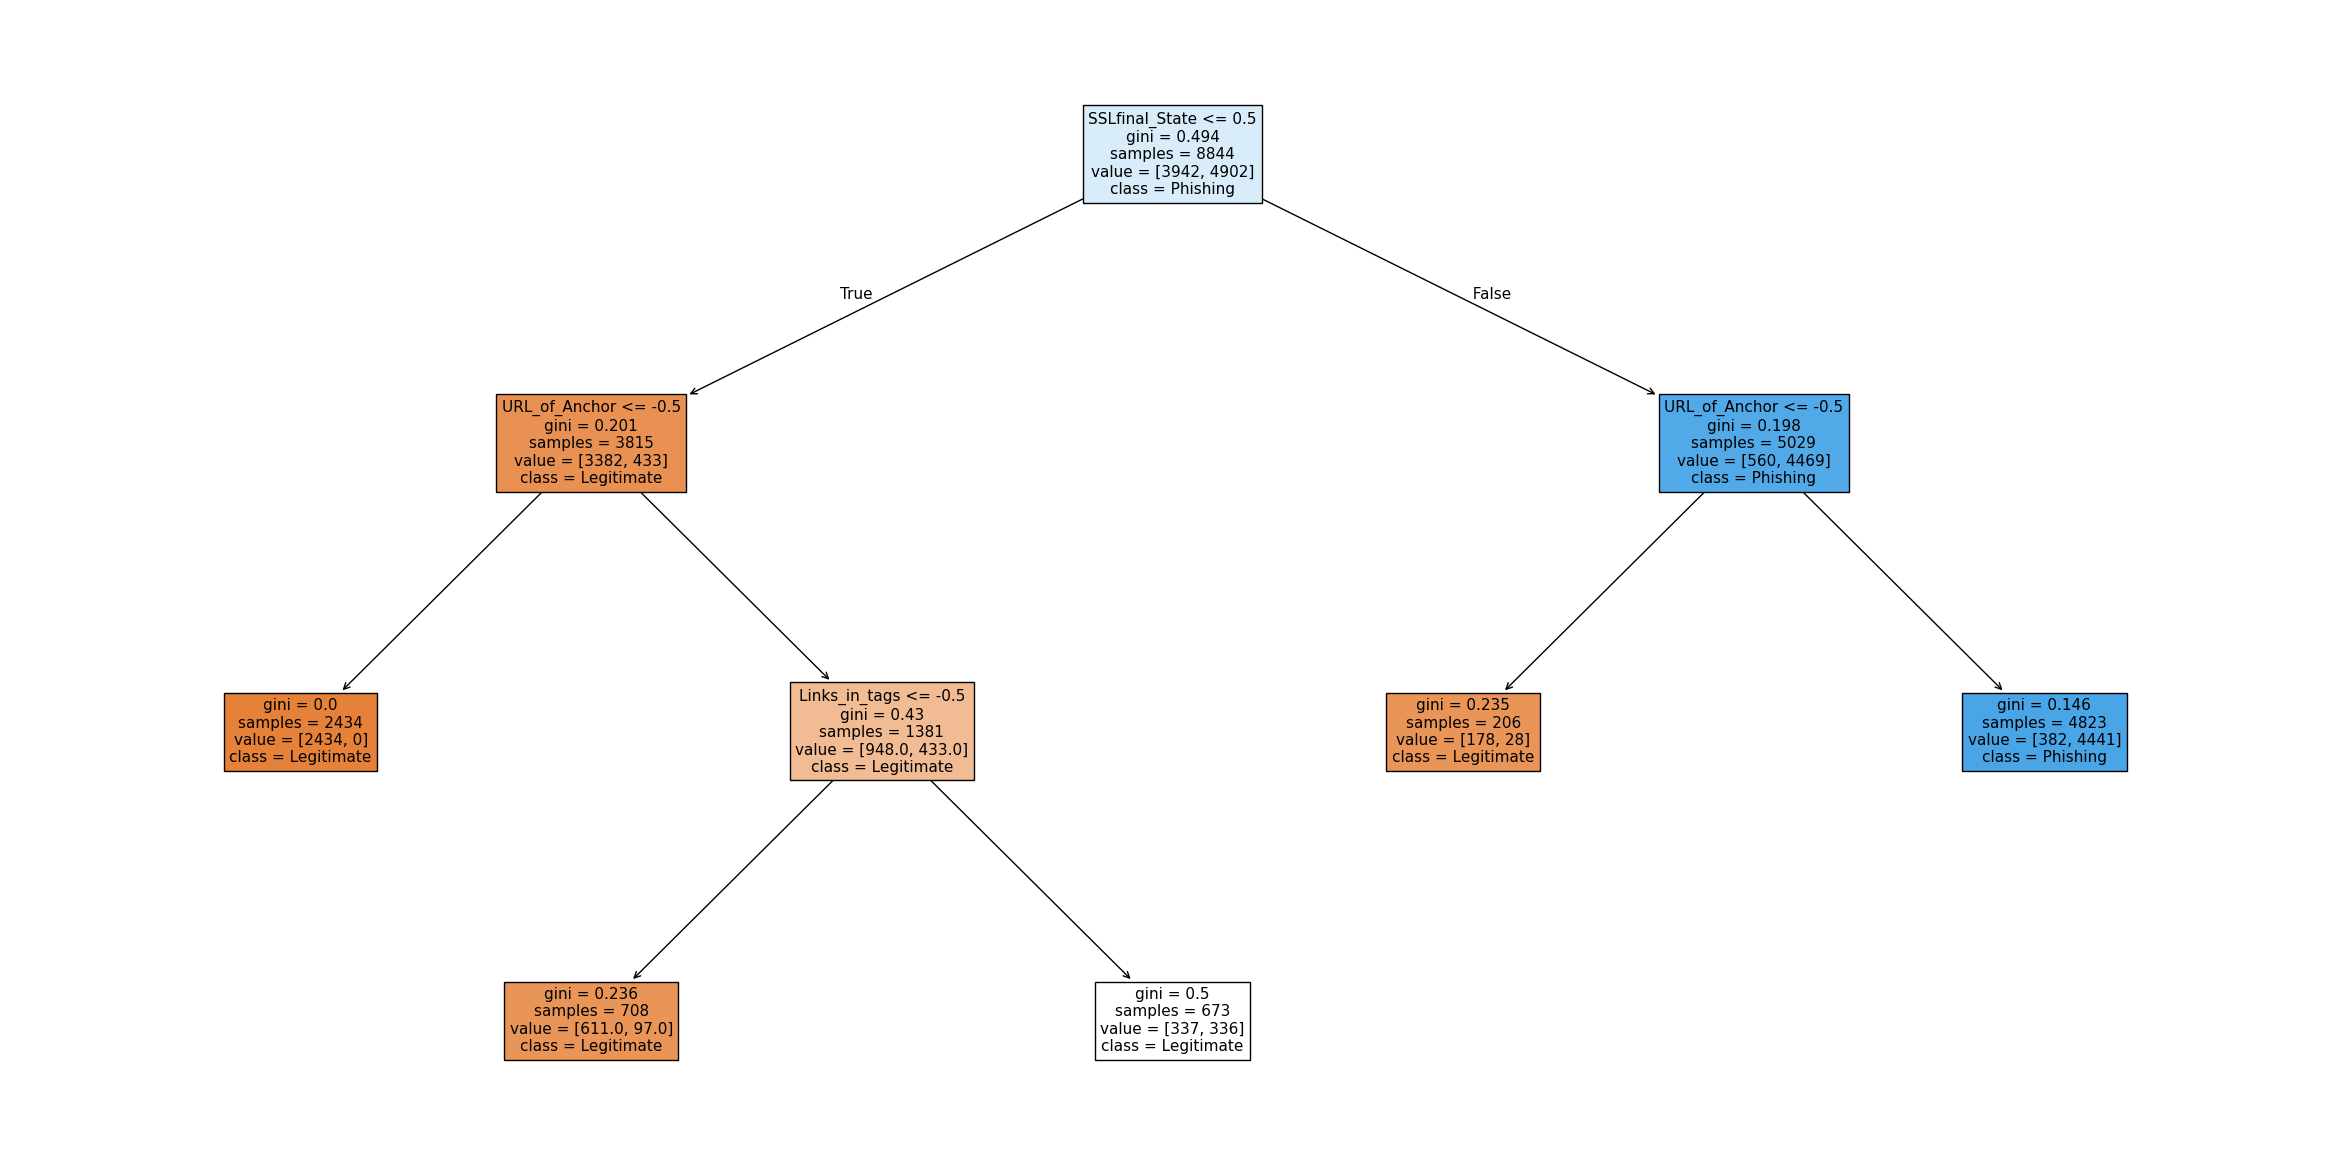

In [2]:
# Part 1: Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, ccp_alpha=0.01)
dt_model.fit(X_train, y_train)

fig = plt.figure(figsize=(30,15))
plot_tree(dt_model, feature_names=X.columns, filled=True, fontsize=11, class_names=['Legitimate', 'Phishing'])
plt.show()

## Puun selitys
Kaikkien arvojen tarkemmat selitykset löytyvät tiedoston toisesta solusta.

Arvojen selitys:
- -1 = Aito(Legitimate)
- 0 = Epäilyttävä(Suspicious)
- 1 = Phishing

Näitä arvoja ei saa sekoittaa result-arvoihin, koska result-arvoissa ei esiinny epäilyttäviä arvoja.

- Root node: Tarkista **SSLfinal_State**-arvo:
    - True: Arvo on `0` tai `-1`, eli sivusto on joko luokiteltu aidoksi tai epäilyttäväksi. Koska aidot ja epäilyttävät arvot menevät tähän luokitteluun, ainoa erottava tekijä olisi tässä se, onko sivustolla HTTPS-sertifikaatti vai ei.
        - Tarkista **URL_of_Anchor**-arvo:
            - True: Arvo on `-1`, eli kaikista sivuston linkeistä alle `31%` on ankkurilinkkejä tai viaraaseen domainiin meneviä linkkejä. 
                - Lehti: Kaikki 2434 sivua ovat aitoja sivuja.
            - False:  Arvo on `0` tai `1`, eli yli `31%` sivuston kaikista linkeistä ovat joko tyhjiä, tai johtavat eri domainille.
                - Tarkista **Links_in_tags**-arvo:
                    - True: Arvo on `-1`, eli alle `17%` sivun `meta` ja `link` tageistä ohjaa domainin ulkopuolelle.
                        - Lehti: Löysimme `611` aitoa sivua, mutta `97` phishing sivua on silti väärin luokiteltu aidoiksi.
                    - False: Arvo on `0` tai `1`, eli yli `17%` sivun `meta` ja `link` tageistä ohjaa domainin ulkopuolelle.
                        - Lehti: Löysimme `337` aitoa sivua, mutta `336` phishing-sivua on silti väärin luokiteltu aidoiksi.
    - False: Arvo on `1`, eli sivustosta ei löydy HTTPS-sertifikaattia ja se on luokiteltu phishing-sivustoksi.
        - Tarkista **URL_of_Anchor**-arvo:
            - True: Arvo on `-1`, eli kaikista sivuston linkeistä alle `31%` on ankkurilinkkejä tai viaraaseen domainiin meneviä linkkejä.
                - Lehti: Löysimme `178` aitoa sivua, mutta `28` phishing-sivua on silti väärin luokiteltu aidoiksi.
            - False:  Arvo on `0` tai `1`, eli yli `31%` sivuston kaikista linkeistä ovat joko tyhjiä, tai johtavat eri domainille.
                - Lehti: Löysimme `4441` phishing-sivua, mutta `382` aitoa sivua on silti väärin luokiteltu phishing-sivuiksi.

Accuracy of decision tree classifier on the test set: 0.91
Precision of decision tree classifier on the test set: 0.89
Recall of decision tree classifier on the test set: 0.90


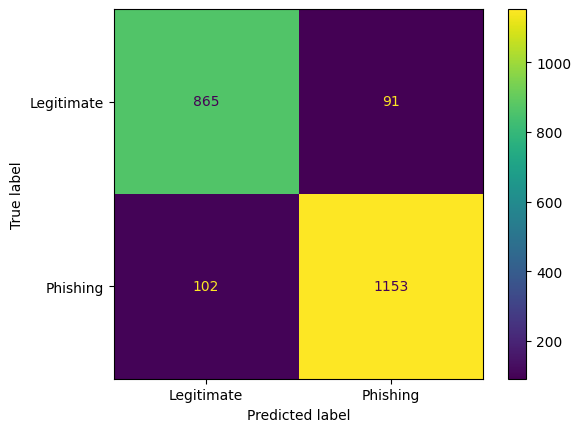

In [3]:
preds = dt_model.predict(X_test)
cm = confusion_matrix(y_test, preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Legitimate','Phishing'])
cmd.plot()

print(f"Accuracy of decision tree classifier on the test set: {accuracy_score(y_test, preds):.2f}")
print(f"Precision of decision tree classifier on the test set: {precision_score(y_test, preds, pos_label=-1):.2f}")
print(f"Recall of decision tree classifier on the test set: {recall_score(y_test, preds, pos_label=-1):.2f}")

## Mallin 1 mallinnus ja arviointi
Tässä kohdassa käytettiin päätöspuuta koneoppimismallina. Asetimme puulle ccp_alpha arvoksi `0.01`, koska tällä arvolla sai parhaat tulokset. Arvo oli myös mukava kompromissi tehokkuuden ja koon välillä, jotta puun toiminta olisi helpompi selittää. Puun suorituskyky vaikuttaa olevan melko hyvä, puun accuracy, precision ja recall arvot ovat kaikki lähes `90%`. Malli täyttää meidän asettamamme vaalimukset phishing- ja aitojen sivujen aroavaisuuksien tunnistukseen.

Seuraavaksi teemme uuden koneoppimismallin, mutta tällä kertaa käytämme satunnaismetsää päätöspuun sijasta.

In [4]:
# Part 2: Random Forest
rf_model = RandomForestClassifier(n_estimators=326, bootstrap=True, max_samples=0.6, max_features=0.8, random_state=123)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_features=0.8, max_samples=0.6, n_estimators=326,
                       random_state=123)

Accuracy of random forest classifier on the test set: 0.96
Precision of random forest classifier on the test set: 0.97
Recall of random forest classifier on the test set: 0.95


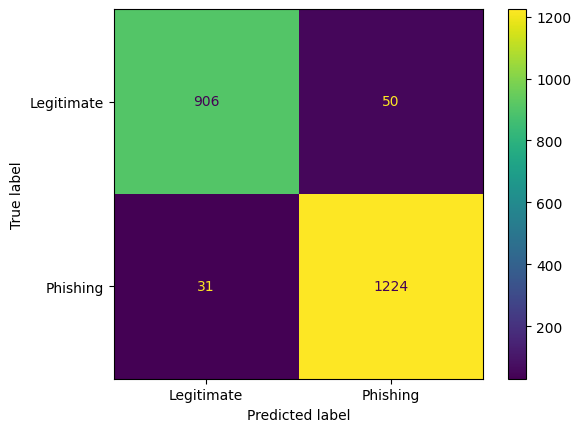

In [5]:
preds_rf = rf_model.predict(X_test)
cm = confusion_matrix(y_test, preds_rf)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Legitimate','Phishing'])
cmd.plot()

print(f"Accuracy of random forest classifier on the test set: {accuracy_score(y_test, preds_rf):.2f}")
print(f"Precision of random forest classifier on the test set: {precision_score(y_test, preds_rf, pos_label=-1):.2f}")
print(f"Recall of random forest classifier on the test set: {recall_score(y_test, preds_rf, pos_label=-1):.2f}")

## Mallin 2 mallinnus ja arviointi
Malli 2 antaa huomattavasti tarkempia ennustuksia, kuin malli 1. Kokeilimme erilaisia arvoja `n_estimators`, `max_samples` ja `max_features` parametreihin. Päädyimme lopulta näihin arvoihin, koska ne antoivat meille parhaimpia tuloksia. Satunnaismetsän suorituskyky näyttäisi olevan todella hyvä, kaikki validaatioarvot ovat yli 95%. Tämä malli vastaa dokumentin alussa laadittuihin vaatimuksiin, eli phishing sivujen tunnistamiseen, korkealla onnistumisprosentilla.

## Käyttöönotto
Malleja voitaisiin käyttää esimerkiksi selainlisäosassa, joka voisi skannata sivustolta löytyviä linkkejä ja arvioida niiden luotettavuutta. Jos lisäosa tunnistaisi sivun epäilyttäväksi, siitä voitaisiin ilmoittaa käyttäjälle popup-ilmoituksella. Käyttäjä voisi syöttää lisäosaan myös yksittäisiä url-osoitteita, jolloin lisäosa tutkisi sivun läpikotaisin ja ilmoittaisi käyttäjälle sivun turvallisuuden. 